In this notebook, we examine image correlation techniques in the framework of an inverse problem. This is based on [Hild and Roux (2006)](https://arxiv.org/ftp/physics/papers/0511/0511122.pdf).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
import numpy as np
from ipywidgets import interact

# Theoretical background 

Let $f$ and $g$ be two grayscale images. $f$ is the original image and $g$ is its advected form by a displacement field, such that 

$$
g(\vec{x} + \vec{u}) = f(\vec{x})
$$

We can introduce a functional $\phi$ that operates on displacement fields that quantifies the distance between the two advected images:

$$
\phi(\vec{v}) = \iint_\Omega [g(\vec{x} + \vec{v}) - f(\vec{x})]^2 d\Omega
$$

When the displacement field $\vec{v}$ is small, the functional can be written 
$$
\phi(\vec{v}) = \iint_\Omega [g(\vec{x}) - f(\vec{x}) + \vec{\nabla g} \cdot \vec{v}]^2 d\Omega
$$

The gradient of this functional in a direction $\vec{w}$ is then

$$
\frac{\partial D}{\partial \vec{w}} = 2 \iint_\Omega [g(\vec{x}) - f(\vec{x}) + \vec{\nabla g} \cdot \vec{v}] \vec{\nabla g} d\Omega
$$

At a minimum of the function $\phi$, the gradient $\frac{\partial D}{\partial \vec{w}}$ should be zero (necessary optimality condition). 

If one writes the displacement field  $\vec{v}$ as a linear combination of basis functions  

$$
\vec{v} = \sum_{i=1}^N v_i \vec{\eta_i (\vec{x})}
$$

Then the optimality condition becomes, for each basis function $\vec{\eta_j}$, the following 

$$
 \sum_{i=1}^N v_i \iint_\Omega (\vec{\nabla g} \cdot \vec{\eta_i}) (\vec{\nabla g} \cdot \vec{\eta_j}) d\Omega = \iint_\Omega [f(\vec{x}) - g(\vec{x})] \vec{\nabla g} \cdot \vec{\eta_j} d\Omega
$$

This means that we can finally write this problem in matrix form:

$$
M V = m
$$

# Solution using finite elements 

Let's solve the above problem using finite elements. For finite elements to work we need:

- nodes
- elements, made of nodes
- connectivity information: a node to element dictionary
- basis functions

## Nodes 

Let's start with the nodes. Each node is defined by its two coordinates, $x$ and $y$ and a label (its Id). As a sample problem for this part, we will work with 12 nodes. 4 along the $x$ direction and 3 along the $y$ direction. We will use the meshgrid machinery to store the information. This means the first axis of coordinate matrices will be the $y$ axis and the second one the $x$ axis. See [this blog post](http://eli.thegreenplace.net/2014/meshgrids-and-disambiguating-rows-and-columns-from-cartesian-coordinates/) for more information about this.

In [2]:
x = np.arange(4)
y = np.arange(3)
X, Y = np.meshgrid(x, y)

In [3]:
X

array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])

In [4]:
Y

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2]])

The meshgrid above holds the information about the grid elements. Let's build a `nodes` dictionary that maps indexes to $x$ and $y$ coordinates.

In [5]:
nodes = {}
for i in range(X.ravel().size):
    nodes[i] = (X.ravel()[i], Y.ravel()[i])

We can now plot this.

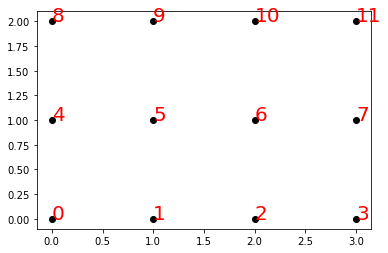

In [6]:
for id in nodes.keys():
    local_x, local_y = nodes[id]
    plt.plot(local_x, local_y, 'ko')
    plt.text(local_x, local_y, str(id), fontdict={'color': 'red', 'fontsize': 20})

## Mesh elements

Let's now build elements: these objects have the knowledge of neighbours with each other.

Here, indexing conventions are important. We will use the following notation *bottom left*, *bottom right*, *top left*, *top right*. Each elements gets an index to the node it is connected to.

In [184]:
class Q1Element:
    """Class that describes a Q1 element with four nodes."""
    def __init__(self, neighbors):
        bottom_left_id, bottom_right_id, top_left_id, top_right_id = neighbors
        self.bottom_left_id = bottom_left_id
        self.bottom_right_id = bottom_right_id
        self.top_left_id = top_left_id
        self.top_right_id = top_right_id
        
    def all_ids(self):
        """Returns all node ids connected in element."""
        return self.bottom_left_id, self.bottom_right_id, self.top_left_id, self.top_right_id

Let's now build our elements.

In [202]:
elements = {}
col_index = 0
row_index = 0
n = 0
while row_index + 1 < y.size:
    bl_id = col_index + row_index * x.size
    br_id = bl_id + 1
    tl_id = bl_id + x.size
    tr_id = tl_id + 1
    elements[n] = Q1Element((bl_id, br_id, tl_id, tr_id))
    n += 1
    col_index += 1
    if col_index + 1 == x.size:
        row_index += 1
        col_index = 0

Let's check we have ended up with 6 elements.

In [203]:
len(elements.keys())

6

In [204]:
elements[5].all_ids()

(6, 7, 10, 11)

## Connectivity: node to elements 

Finally, let's build a node to element dictionary that tells us, for a given node id, which elements it is present in.

In [205]:
node_to_elements = {}
for element_id in elements:
    element = elements[element_id]
    for node_id in element.all_ids():
        if node_id in node_to_elements:
            node_to_elements[node_id].append(element_id)
        else:
            node_to_elements[node_id] = [element_id]

Let's check the output of this dictionary.

In [206]:
node_to_elements

{0: [0],
 1: [0, 1],
 2: [1, 2],
 3: [2],
 4: [0, 3],
 5: [0, 1, 3, 4],
 6: [1, 2, 4, 5],
 7: [2, 5],
 8: [3],
 9: [3, 4],
 10: [4, 5],
 11: [5]}

So we see that everything seems normal here: most nodes are connected to four elements, but some are only connected to two (mesh edges) or just one (corner points).

## Element basis function 

Let's now define our [Q1 finite element basis functions](http://people.inf.ethz.ch/arbenz/FEM16/pdfs/0-19-852868-X.pdf). One element is defined by the value it takes on the four edges of the quadrilateral element.

The element basis functions for $[0, 1] \times [0, 1] $are:

$$
\left\{ 
\begin{array}{lr} 
(1 − x)(1 − y)\\
x(1 − y)\\
xy\\
(1 − x)y
\end{array}
\right.
$$

Let's look at what these element basis functions looks like in 2D and 3D.

In [207]:
def q1_element_func(a, b, c, d):
    """Returns a function valid on the hxh square."""
    bl = lambda y,x: (1 - x)*(1 - y) # bl
    br = lambda y,x: (1 - x) * y # br
    tl = lambda y,x: x*(1 - y) # tl
    tr = lambda y,x: x * y # tr
    return lambda x,y: a * bl(x,y) + b * br(x,y) + c * tl(x,y) + d * tr(x,y)

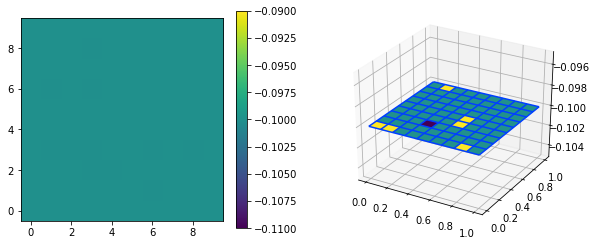

In [208]:
from mpl_toolkits.mplot3d import Axes3D

@interact
def plot_finite_element(a=(-1, 1, 0.1), 
                        b=(-1, 1, 0.1), 
                        c=(-1, 1, 0.1), 
                        d=(-1, 1, 0.1)):
    """Demonstrates the Q1 finite element in an interactive way."""
    num = 10
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    
    basis_func = q1_element_func(a, b, c, d)
    x = np.linspace(0, 1, num=num)
    y = np.linspace(0, 1, num=num)
    X, Y = np.meshgrid(x, y)
    mapping = basis_func(X, Y)
    mappable = ax1.imshow(mapping, origin='lower')
    plt.colorbar(mappable)
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, mapping, cmap='viridis')
    ax2.plot_wireframe(X, Y, mapping)
    

Let's do a plot for each the basis functions.

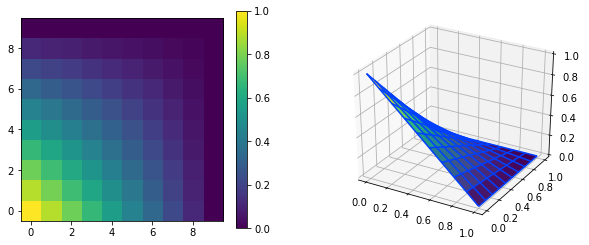

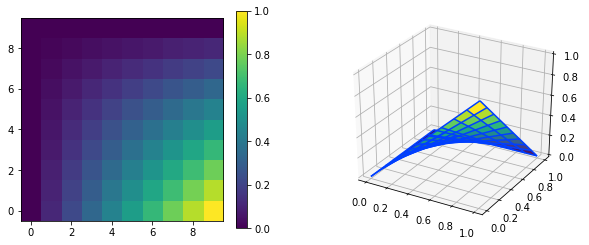

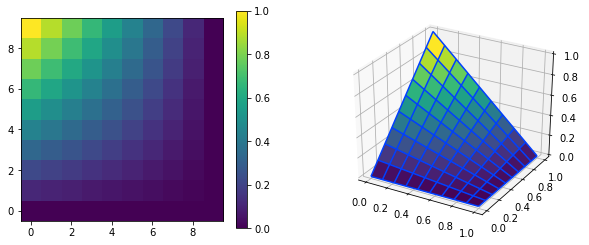

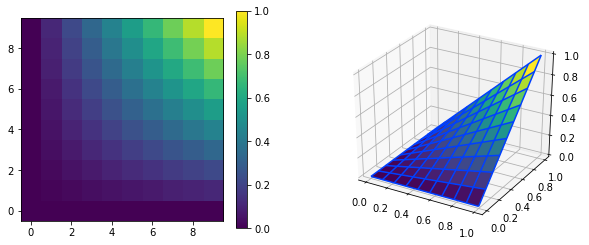

In [209]:
plot_finite_element(1, 0, 0, 0)
plot_finite_element(0, 1, 0, 0)
plot_finite_element(0, 0, 1, 0)
plot_finite_element(0, 0, 0, 1)

## Nodal basis functions

Now that we have the element basis functions, we can use them to build nodal basis functions. How? By noting that each node is connected to several elements and that over each element, the node occupies a different location. Thus by setting the nodal value to 1 and evaluating the element basis functions over the right coordinates we can evaluate these nodal functions everywhere on the mesh.

Let's build a finer grid for evaluating the nodal basis functions.

In [237]:
x_fine = np.linspace(0, 3, num=20, endpoint=False)
y_fine = np.linspace(0, 2, num=13, endpoint=False)
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)

We then need to translate the coordinates to the origin of the local element, its bottom left corner.

In [238]:
nodal_basis_index = 3

In [239]:
local_X = X_fine - nodes[nodal_basis_index][0]
local_Y = Y_fine - nodes[nodal_basis_index][1]

We also build the mask that allows us to restrict the evaluation to a single element.

In [240]:
mask = (local_X >= 0) & (local_X <= 1) & (local_Y >= 0) &  (local_Y <= 1)

We want to visualize the output of only one corner of the function so we set just one coordinate to 1 and the others to 0 and evaluate the function.

In [241]:
a, b, c, d = 1, 0, 0, 0
basis_func = q1_element_func(a, b, c, d)
mapping = basis_func(local_X, local_Y) * mask

Let's now plot this.

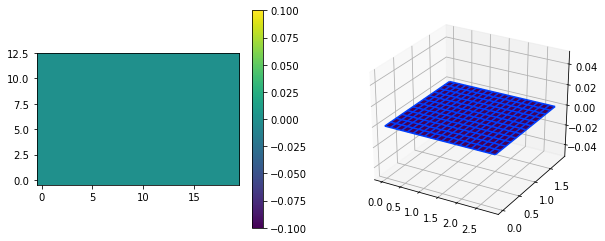

In [242]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
mappable = ax1.imshow(mapping, origin='lower')
plt.colorbar(mappable)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_fine, Y_fine, mapping, cmap='viridis')
ax2.plot_wireframe(X_fine, Y_fine, mapping)

Let's now loop over this construction to build a full nodal element.

In [243]:
mapping = np.zeros_like(X_fine)
for element_id in node_to_elements[nodal_basis_index]:
    connected_nodes = elements[element_id].all_ids()
    element_origin_node_id = connected_nodes[0]
    local_X = X_fine - nodes[element_origin_node_id][0]
    local_Y = Y_fine - nodes[element_origin_node_id][1]
    mask = (local_X >= 0) & (local_X <= 1) & (local_Y >= 0) &  (local_Y <= 1)
    weights = [0, 0, 0, 0]
    weights[connected_nodes.index(nodal_basis_index)] = 1
    basis_func = q1_element_func(*weights)
    mapping += basis_func(local_X, local_Y) * mask

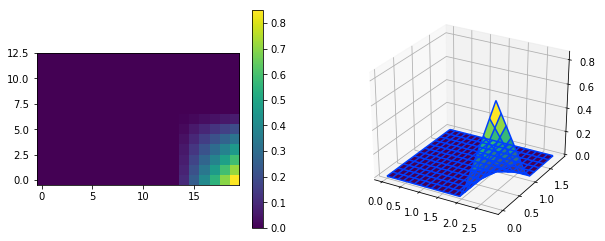

In [244]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
mappable = ax1.imshow(mapping, origin='lower')
plt.colorbar(mappable)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_fine, Y_fine, mapping, cmap='viridis')
ax2.plot_wireframe(X_fine, Y_fine, mapping)

So now we have our approximation on the fine grid and it looks good. We can do the same for every nodal basis function.

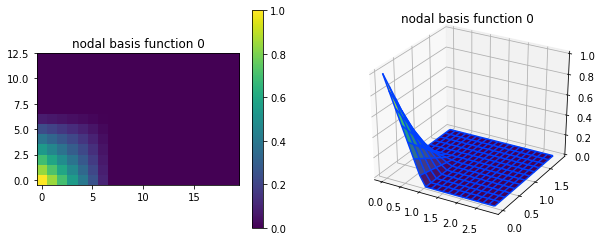

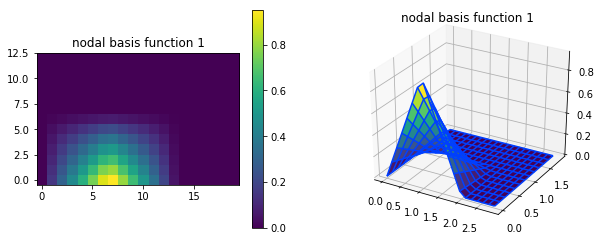

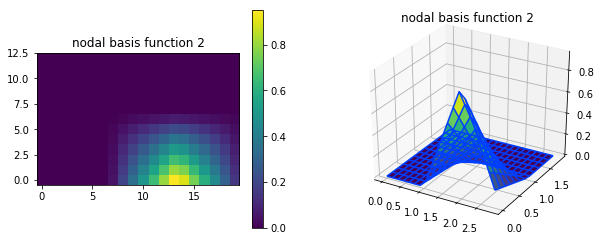

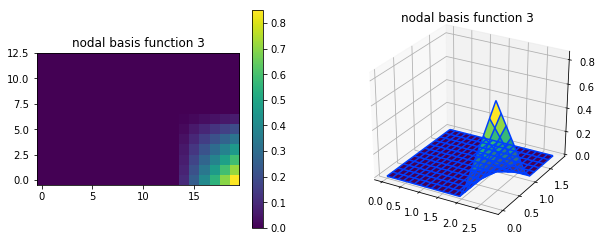

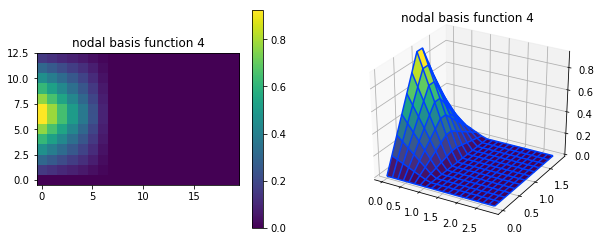

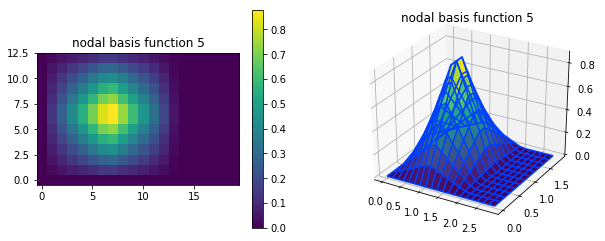

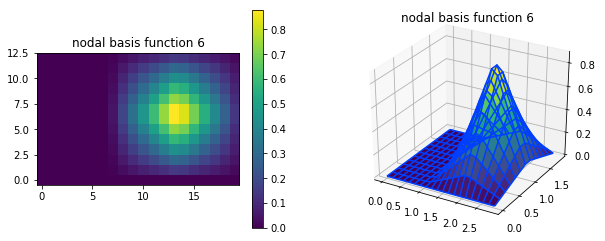

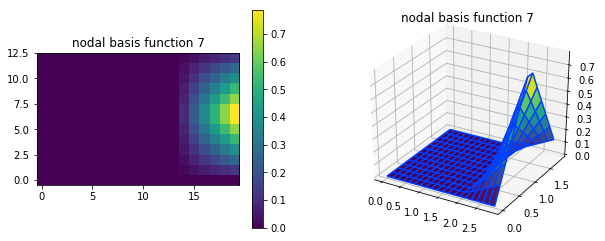

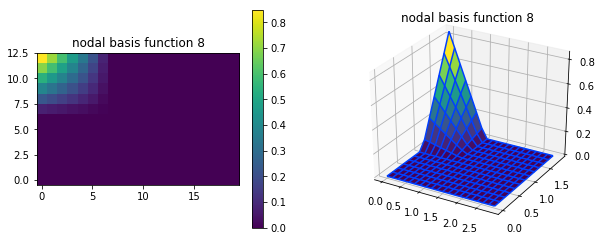

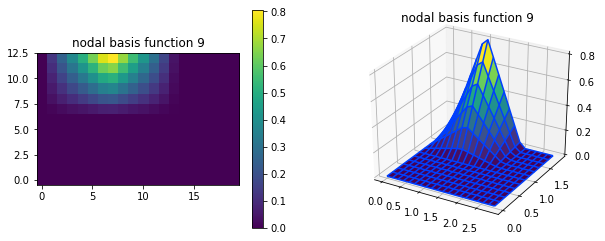

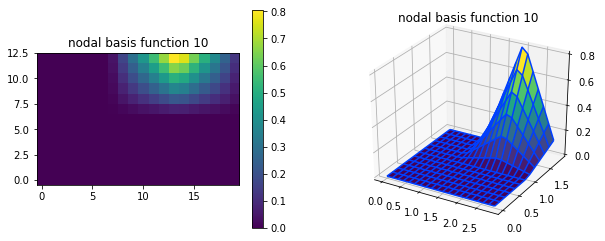

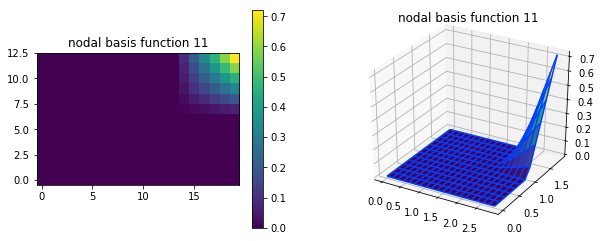

In [245]:
for nodal_basis_index in nodes.keys():

    mapping = np.zeros_like(X_fine)
    for element_id in node_to_elements[nodal_basis_index]:
        connected_nodes = elements[element_id].all_ids()
        element_origin_node_id = connected_nodes[0]
        local_X = X_fine - nodes[element_origin_node_id][0]
        local_Y = Y_fine - nodes[element_origin_node_id][1]
        mask = (local_X >= 0) & (local_X < 1) & (local_Y >= 0) &  (local_Y < 1)
        weights = [0, 0, 0, 0]
        weights[connected_nodes.index(nodal_basis_index)] = 1
        basis_func = q1_element_func(*weights)
        mapping += basis_func(local_X, local_Y) * mask

    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    ax1.set_title('nodal basis function {}'.format(nodal_basis_index))
    mappable = ax1.imshow(mapping, origin='lower')
    plt.colorbar(mappable)
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('nodal basis function {}'.format(nodal_basis_index))
    ax2.plot_surface(X_fine, Y_fine, mapping, cmap='viridis')
    ax2.plot_wireframe(X_fine, Y_fine, mapping)

## Representing any field over the grid 

Now that we have come to this point, we can see how our finite element approximation works. By simply injecting nodal values into our grid, we can represent much more complicated fields. Let's apply this principle by injecting random values into the nodes and then build the whole field from these values.

In [246]:
node_values = dict(zip(nodes.keys(), np.random.random(len(nodes.keys()))))
node_values

{0: 0.1595409117633908,
 1: 0.90626832185077189,
 2: 0.30276265405465586,
 3: 0.97946213017032902,
 4: 0.36961841347138691,
 5: 0.39152180479507004,
 6: 0.90720784606670901,
 7: 0.84220810927418333,
 8: 0.10880048635040884,
 9: 0.84209998371446726,
 10: 0.15838646079249263,
 11: 0.15456459018403634}

First, let's represent this using markers.

In [247]:
from matplotlib.colors import Normalize 
from matplotlib.cm import ScalarMappable

In [248]:
normer = Normalize(vmin=min(node_values.values()), vmax=max(node_values.values()))
mapper = ScalarMappable(normer, cmap='viridis')

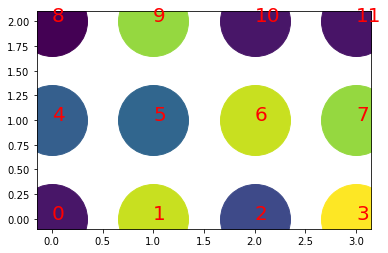

In [252]:
for id, node_value in zip(nodes.keys(), node_values.values()):
    local_x, local_y = nodes[id]
    plt.plot(local_x, local_y, 'o', color=mapper.to_rgba(node_value), ms=70)
    plt.text(local_x, local_y, str(id), fontdict={'color': 'red', 'fontsize': 20})

Let's now loop over all elements and sum the contributions of each node to build a continuous map.

In [253]:
mapping = np.zeros_like(X_fine)
for element_id in elements:
    connected_nodes = elements[element_id].all_ids()
    element_origin_node_id = connected_nodes[0]
    local_X = X_fine - nodes[element_origin_node_id][0]
    local_Y = Y_fine - nodes[element_origin_node_id][1]
    mask = (local_X >= 0) & (local_X < 1) & (local_Y >= 0) &  (local_Y < 1)
    weights = [node_values[i] for i in connected_nodes]
    basis_func = q1_element_func(*weights)
    mapping += basis_func(local_X, local_Y) * mask

And let's plot it: 

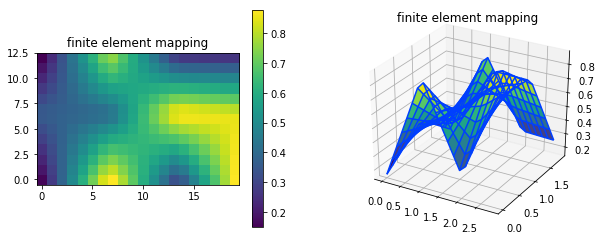

In [254]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.set_title('finite element mapping'.format(nodal_basis_index))
mappable = ax1.imshow(mapping, origin='lower')
plt.colorbar(mappable)
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('finite element mapping'.format(nodal_basis_index))
ax2.plot_surface(X_fine, Y_fine, mapping, cmap='viridis')
ax2.plot_wireframe(X_fine, Y_fine, mapping)

This compares well with the above plot that used only colored dots. We see here the advantage of using a mesh instead of just points: we can map to a continuous representation quite easily.

## Assembling the matrix 1: sparsity 

Now that we have come this far, we have to compute the terms of the $M$ matrix, as well as the $m$ matrix. Since the displacement field we are looking for is composed of components along the x direction and along the y direction at each node of the image, this means that the M matrix will be sparse. For each basis function, of which there are N_pixels * N_pixels, we need to compute the value in the.

## Assembling the matrix 2: filling in the values 

In [24]:
for basis_function in funcs:
    for other_basis_function in funcs:
        if common_edge(basis_function, other_basis_function):
            compute_coef(basis_function, other_basis_function)

NameError: name 'funcs' is not defined

## Choosing an image to start with

First, let's choose an image to start with.

In [ ]:
from skimage.data import astronaut
from skimage.color import rgb2gray

In [ ]:
f = rgb2gray(astronaut())

In [ ]:
plt.imshow(f, cmap='gray')
plt.colorbar()

Let's now transform this image using a certain displacement field. We will use the [scikit-image swirl operation](http://scikit-image.org/docs/dev/auto_examples/transform/plot_swirl.html#sphx-glr-auto-examples-transform-plot-swirl-py) for this 

In [ ]:
from skimage.transform import swirl
g = swirl(f, rotation=0, strength=1, radius=500)

In [ ]:
plt.imshow(g, cmap='gray')
plt.colorbar()